In [1]:
### PREDICT ONLY SEA ICE U & V

# Ignore warning
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import netCDF4
import h5py
import datetime as dt
import pyproj

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers.convolutional import Conv3D
from tqdm import tqdm

from pyproj import Proj, transform
from shapely.geometry import Polygon
import cartopy.crs as ccrs

from scipy.interpolate import griddata

import cdsapi
import xarray as xr
from urllib.request import urlopen

import pickle

from functions import *


# check pytorch version
import torch
    
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torch_cluster import knn_graph


import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

ModuleNotFoundError: No module named 'torch_cluster'

In [19]:
################################################################################

class custom_loss(nn.Module):
    def __init__(self):
        super(custom_loss, self).__init__();

    def forward(self, obs, prd):
        err_u = torch.abs(obs[:, 0, :, :]-prd[:, 0, :, :])
        err_v = torch.abs(obs[:, 1, :, :]-prd[:, 1, :, :])
        err_sic = torch.abs(obs[:, 2, :, :]-prd[:, 2, :, :])
        
        err_sum = torch.mean((err_u + err_v) + err_sic)
        # err_sum = tf.sqrt(tf.reduce_mean(err_u*err_sic)) + tf.sqrt(tf.reduce_mean(err_v*err_sic))
        return err_sum*100
    
    
class physics_loss(nn.Module):
    def __init__(self):
        super(custom_loss, self).__init__();

    def forward(self, obs, prd):
        err_u = torch.abs(obs[:, 0, :, :]-prd[:, 0, :, :])
        err_v = torch.abs(obs[:, 1, :, :]-prd[:, 1, :, :])
        err_sic = torch.abs(obs[:, 2, :, :]-prd[:, 2, :, :])
        
        err_sum = torch.mean((err_u + err_v) + err_sic)
        # err_sum = tf.sqrt(tf.reduce_mean(err_u*err_sic)) + tf.sqrt(tf.reduce_mean(err_v*err_sic))
        
        u = prd[:, 0, :, :]
        v = prd[:, 1, :, :]
        d_sic = prd[:, 2, 1:-1, 1:-1]
        
        dy = prd[:, 1, 2:, 1:-1] - prd[:, 1, :-2, 1:-1]
        dx = prd[:, 0, 1:-1, 2:] - prd[:, 0, 1:-1, :-2]
        div = dx/50 + dy/50
        
        # SIC change
        err_phy = torch.mean(torch.where((div > 0) & (d_sic > 0), div * err_sic, 0))
        # err_phy = torch.mean(torch.where((div > 0) & (d_sic > 0), err_u + err_v + err_sic, 0))
        
        w = torch.tensor(1.0)
        err_sum += w*err_phy
        
        return err_sum*100
    
# model definition
class MLP(nn.Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.layer = Linear(n_inputs, 1)
        self.activation = Sigmoid()
 
    # forward propagate input
    def forward(self, X):
        X = self.layer(X)
        X = self.activation(X)
        return X


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(6, 16, 5, padding = "same")
        self.conv2 = nn.Conv2d(16, 16, 5, padding = "same")
        self.conv3 = nn.Conv2d(16, 16, 5, padding = "same")
        self.conv4 = nn.Conv2d(16, 16, 5, padding = "same")
        self.conv5 = nn.Conv2d(16, 16, 5, padding = "same")
        self.conv6 = nn.Conv2d(16, 16, 5, padding = "same")
        self.conv7 = nn.Conv2d(16, 16, 5, padding = "same")
        self.conv8 = nn.Conv2d(16, 3, 5, padding = "same")

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=1)
        x = F.leaky_relu(self.conv2(x), negative_slope=1)
        x = F.leaky_relu(self.conv3(x), negative_slope=1)
        x = F.leaky_relu(self.conv4(x), negative_slope=1)
        x = F.leaky_relu(self.conv5(x), negative_slope=1)
        x = F.leaky_relu(self.conv6(x), negative_slope=1)
        x = F.leaky_relu(self.conv7(x), negative_slope=1)
        x = F.leaky_relu(self.conv8(x), negative_slope=1)
        
        # x = F.linear(self.conv1(x), weight = torch.flatten(torch.ones(x.size())))
        # x = F.linear(self.conv2(x), weight = torch.flatten(torch.ones(x.size())))
        # x = F.linear(self.conv3(x), weight = torch.flatten(torch.ones(x.size())))
        # x = F.linear(self.conv4(x), weight = torch.flatten(torch.ones(x.size())))
        # x = F.linear(self.conv5(x), weight = torch.flatten(torch.ones(x.size())))
        # x = F.linear(self.conv6(x), weight = torch.flatten(torch.ones(x.size())))
        # x = F.linear(self.conv7(x), weight = torch.flatten(torch.ones(x.size())))
        # x = F.linear(self.conv8(x), weight = torch.flatten(torch.ones(x.size())))
        
        return x
    
##########################################################################################3



In [11]:
torch.ones(2220)

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [9]:
data_path = "D:\\PINN\\data"

with open(data_path + '/train_cnn_2019_2021.pkl', 'rb') as file:
    xx, yy, days, months, years, cnn_input, cnn_output = pickle.load(file)
    
print("######## TRAINING DATA IS PREPARED (# of samples: {0}) ########".format(len(days)))

cnn_input = np.transpose(cnn_input, (0, 3, 1, 2))
cnn_output = np.transpose(cnn_output, (0, 3, 1, 2))

print(np.shape(cnn_input), np.shape(cnn_output))

date = 2019

mask1 = (years == date) # Test samples
mask2 = (days % 4 == 2) # Validation samples

test_input = cnn_input[mask1, :, 41:, :-41]
test_output = cnn_output[mask1, :, 41:, :-41]
val_input = cnn_input[(~mask1)&(mask2), :, 41:, :-41]
val_output = cnn_output[(~mask1)&(mask2), :, 41:, :-41]
train_input = cnn_input[(~mask1)&(~mask2), :, 41:, :-41]
train_output = cnn_output[(~mask1)&(~mask2), :, 41:, :-41]

del mask1, mask2

print(np.shape(train_input), np.shape(train_output), np.shape(val_input), np.shape(val_output), np.shape(test_input), np.shape(test_output))

train_input = torch.tensor(train_input, dtype=torch.float32)
train_output = torch.tensor(train_output, dtype=torch.float32)
val_input = torch.tensor(val_input, dtype=torch.float32)
val_output = torch.tensor(val_output, dtype=torch.float32)
test_input = torch.tensor(test_input, dtype=torch.float32)
test_output = torch.tensor(test_output, dtype=torch.float32)

n_samples, row, col, in_channels = np.shape(train_input)
_, _, _, out_channels = np.shape(train_output)


######## TRAINING DATA IS PREPARED (# of samples: 1093) ########
(1093, 6, 361, 361) (1093, 3, 361, 361)
(539, 6, 320, 320) (539, 3, 320, 320) (190, 6, 320, 320) (190, 3, 320, 320) (364, 6, 320, 320) (364, 3, 320, 320)


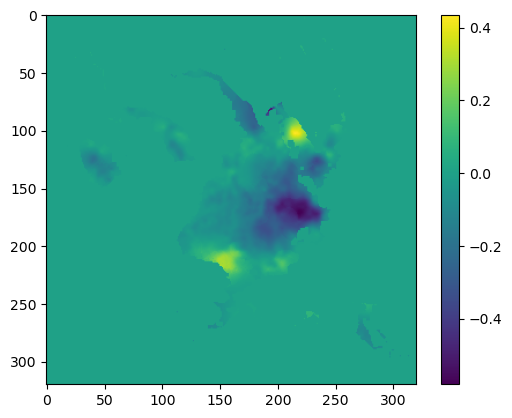

In [6]:
a = train_input[0, 0, :, :];
plt.imshow(a);
plt.colorbar();

In [ ]:
torch.cuda.device_count()

1

In [20]:

net = Net()

device = 'cpu' #torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
net.to(device)

loss_fn = nn.L1Loss() #custom_loss() # nn.L1Loss() #nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

n_epochs = 3
batch_size = 32  # size of each batch
batch_start = torch.arange(0, len(train_input), batch_size)

history = {'loss': [], 'val_loss': []}

total_params = sum(p.numel() for p in net.parameters())
print(f"Number of parameters: {total_params}")

for epoch in range(n_epochs):
    net.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = train_input[start:start+batch_size].to(device)
            y_batch = train_output[start:start+batch_size].to(device)
            # backward pass
            optimizer.zero_grad()
            # forward pass
            y_pred = net(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(loss=float(loss))
    net.eval()
    val_pred = net(val_input.to(device))
    val_loss = loss_fn(val_pred, val_output)
    history['loss'].append(loss.item())
    history['val_loss'].append(val_loss.item())




# for epoch in range(2):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(np.arange(0, n_samples), 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs = train_input[i, :, :, :]

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = loss_fn(outputs, train_output[i, :, :, :])
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 50 == 49:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
#             running_loss = 0.0
            
#     net.eval()
#     train_pred = net(train_input)
#     loss_train = loss_fn(train_pred, train_output)
#     val_pred = net(val_input)
#     loss_val = loss_fn(val_pred, val_output)
#     history.append(mse)

# print('Finished Training')

cpu
Number of parameters: 42115


Epoch 1:  12%|███████                                                     | 2/17 [00:07<00:58,  3.87s/batch, loss=35.9]

KeyboardInterrupt



In [16]:
torch.flatten(torch.ones(test_input.size()))

tensor([1., 1., 1.,  ..., 1., 1., 1.])

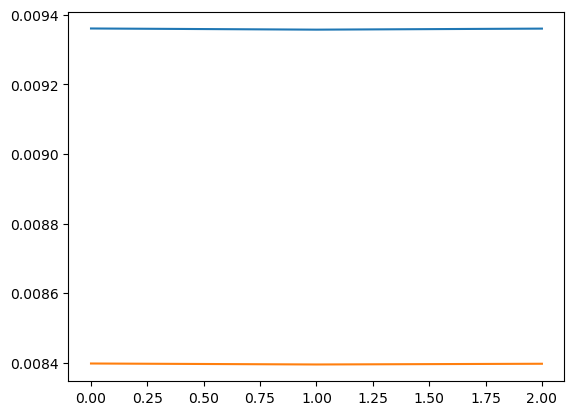

In [23]:
a = [0.009360519237816334, 0.009357145987451077, 0.009360144846141338]
b = [0.008397781290113926, 0.008394971489906311, 0.008397048339247704]
plt.plot(a)
plt.plot(b)

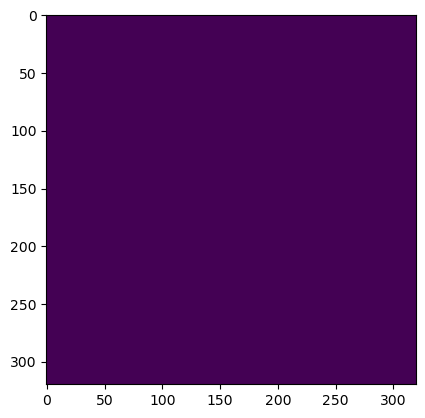

In [156]:
plt.imshow(val_pred[0, 0].detach().numpy())

In [38]:
torch.save(net.state_dict(), '../model/torch_net.pth')

In [46]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.memory_allocated(device)

0

In [2]:
model = Net()
model.load_state_dict(torch.load('../model/torch_net.pth'))
model.eval()

NameError: name 'Net' is not defined

In [1]:
model.conv1

NameError: name 'model' is not defined

In [44]:
torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device(type='cuda', index=0)

In [36]:
model_name = f"torch_conv2d_lr{0.01}_wo{date}_nophy.pth"
torch.save(net, model_name)

PicklingError: Can't pickle <class '__main__.Net'>: it's not the same object as __main__.Net

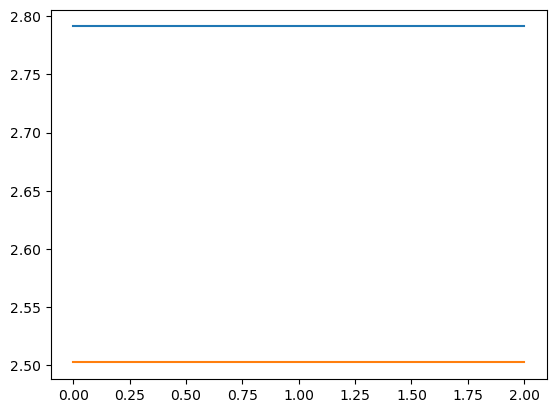

In [150]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

In [48]:
criterion(outputs, test_output)

tensor(0.0074, grad_fn=<MeanBackward0>)

In [40]:
outputs = outputs.detach().numpy()

In [56]:
plt.imshow(outputs[100, 2, :, :])

IndexError: too many indices for tensor of dimension 3

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0
